In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional
from scipy import stats
from sklearn.metrics import f1_score

In [2]:
data1 = pd.read_csv('chips.csv')
data2 = pd.read_csv('geyser.csv')
data1.head()

,x,y,class
0,0.051267,0.69956,P
1,-0.092742,0.68494,P
2,-0.213710,0.69225,P
3,-0.375000,0.50219,P
4,-0.513250,0.46564,P


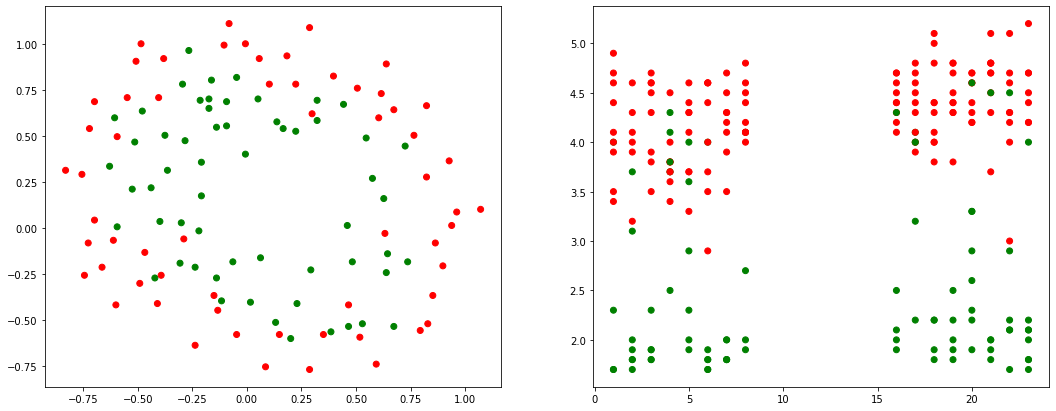

In [3]:
#присвоение "цвета" объектам и их визуализация на scatter plot
def show_points(ax, data):
    data['colors'] = data['class'].apply(lambda c: "green" if c == "P" else "red")
    ax.scatter(data=data, x='x', y='y', c='colors')

_, (axs0, axs1) = plt.subplots(1, 2, figsize=(18, 7))

show_points(axs0, data1)
show_points(axs1, data2)

In [4]:
#реализация алгоритма построения решающего дерева по взвешенным объектам

class Tree:
    def predict(self, _: np.ndarray) -> int:
        return 0


class Node(Tree):
    def __init__(self, v: int, sep: float, left: Tree, right: Tree):
        self.v = v
        self.sep = sep
        self.left = left
        self.right = right

    def predict(self, x: np.ndarray) -> int:
        if x[self.v] < self.sep:
            return self.left.predict(x)
        else:
            return self.right.predict(x)


class Leaf(Tree):
    def __init__(self, c: int):
        self.c = c

    def predict(self, _: np.ndarray) -> int:
        return self.c


def weighted_entropy(y: np.ndarray, w: np.ndarray) -> float:
    w_y = {}
    for yi, wi in zip(y, w):
        w_y[yi] = w_y.get(yi, 0) + wi

    w_sum = sum(w)
    return -sum([w1 / w_sum * np.log(w1 / w_sum) for w1 in w_y.values()])


def branch_criterion(s_entropy: float, y1: np.ndarray, w1: np.ndarray, y2: np.ndarray, w2: np.ndarray) -> float:
    w1_sum = sum(w1)
    w2_sum = sum(w2)
    w_sum = w1_sum + w2_sum
    f_s1 = weighted_entropy(y1, w1) * w1_sum / w_sum
    f_s2 = weighted_entropy(y2, w2) * w2_sum / w_sum
    return s_entropy - f_s1 - f_s2


class DecisionTree:
    def __init__(self, max_depth: int, iters_per_node: int = 10, min_part_size: int = 1):
        self.vars_n = -1
        self.max_depth = max_depth
        self.tries_per_node = iters_per_node
        self.min_part_size = min_part_size
        self.root = None

    def fit(self, x: np.ndarray, y: np.ndarray, w: np.ndarray = None):
        self.vars_n = len(x[0])
        if w is None:
            w = np.ones_like(y)
        self.root = self.build(x, y, w, 1)

        return self

    def predict(self, x: np.ndarray) -> int:
        return self.root.predict(x)

    def build(self, x: np.ndarray, y: np.ndarray, w: np.ndarray, depth: int) -> Tree:
        mode = stats.mode(y)[0][0]
        if depth > self.max_depth:
            return Leaf(mode)

        best_sep, _ = self.split(x, y, w)
        if best_sep is None:
            return Leaf(mode)

        v, sep, (left_x, left_y, left_w), (right_x, right_y, right_w) = best_sep
        left_node = self.build(left_x, left_y, left_w, depth + 1)
        right_node = self.build(right_x, right_y, right_w, depth + 1)
        return Node(v, sep, left_node, right_node)

    def split(self, x: np.ndarray, y: np.ndarray, w: np.ndarray) -> tuple[Optional[tuple[int, float, tuple[np.ndarray, np.ndarray, np.ndarray], tuple[np.ndarray, np.ndarray, np.ndarray]]], Optional[float]]:
        if len(x) <= self.min_part_size or len(np.unique(y)) == 1:
            return None, None

        best_sep, best_score = None, None
        for i in range(self.vars_n):
            sep, score = self.split_i(x, y, w, i)
            if score and (best_score is None or score > best_score):
                best_sep = sep
                best_score = score

        return best_sep, best_score

    def split_i(self, x: np.ndarray, y: np.ndarray, w: np.ndarray, v: int) -> tuple[Optional[tuple[int, float, tuple[np.ndarray, np.ndarray, np.ndarray], tuple[np.ndarray, np.ndarray, np.ndarray]]], Optional[float]]:
        entropy = weighted_entropy(y, w)
        best_sep, best_score = None, None
        random_sep = np.random.uniform(min(x[:, v]), max(x[:, v]), self.tries_per_node)
        for sep in random_sep:
            cond = x[:, v] < sep
            left_x, left_y, left_w = x[cond], y[cond], w[cond]
            right_x, right_y, right_w = x[~cond], y[~cond], w[~cond]
            if len(left_x) == 0 or len(right_x) == 0:
                continue
            score = branch_criterion(entropy, left_y, left_w, right_y, right_w)
            if best_score is None or score > best_score:
                best_sep = (v, sep, (left_x, left_y, left_w), (right_x, right_y, right_w))
                best_score = score

        return best_sep, best_score

In [5]:
#случайный лес

class RandomForest:
    def __init__(self, n_trees: int, iters_per_node: int = 5):
        self.models = [
            DecisionTree(
                max_depth=10000,
                iters_per_node=iters_per_node
            ) for _ in range(n_trees)
        ]

    def fit(self, x: np.ndarray, y: np.ndarray):
        for model in self.models:
            indices = np.random.randint(0, len(x), int(10 * np.sqrt(len(x))))
            model.fit(x[indices], y[indices])
        return self

    def predict(self, x: np.ndarray) -> int:
        decisions = [model.predict(x) for model in self.models]
        return stats.mode(decisions)[0][0]

In [6]:
#Визуализация работы алгоритма случайного леса

def class2int(c: str) -> int:
    return 1 if c == 'P' else -1

def get_xy(data: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    x = np.dstack((data['x'], data['y'])).squeeze()
    y = data['class'].apply(class2int).to_numpy()
    return x, y

def visualize(ax: plt.Axes, data: pd.DataFrame, model):
    x, y = get_xy(data)
    data['colors'] = ["green" if el == 1 else "red" for el in y]
    
    x_min, x_max = min(data['x']), max(data['x'])
    y_min, y_max = min(data['y']), max(data['y'])

    n = 20
    x_range = np.linspace(x_min, x_max, n)
    y_range = np.linspace(y_min, y_max, n)
    xv, yv = np.meshgrid(x_range, y_range)
    z = np.ones_like(xv)
    for i in range(xv.shape[0]):
        for j in range(xv.shape[1]):
            z[i, j] = model.predict([xv[i, j], yv[i, j]])

    ax.imshow(
        z,
        extent=[x_min, x_max, y_min, y_max],
        origin='lower',
        cmap='autumn',
        alpha=0.5,
        aspect='auto',
    )
    ax.scatter(data=data, x='x', y='y', c='colors')

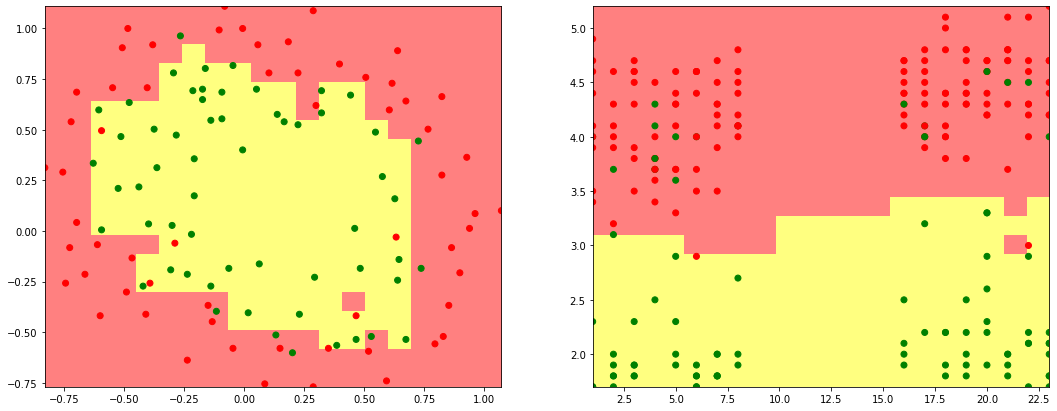

In [7]:
_, (axs0, axs1) = plt.subplots(1, 2, figsize=(18, 7))
model = RandomForest(n_trees=100)

x1, y1 = get_xy(data1)
model.fit(x1, y1)
visualize(axs0, data1, model)

x2, y2 = get_xy(data2)
model.fit(x2, y2)
visualize(axs1, data2, model)

In [8]:
#Алгоритм AdaBoost на решающих деревьях ограниченной малой высоты

class AdaBoost:
    def __init__(self, t: int, max_depth: int = 3, iters_per_node: int = 10):
        self.trees = [DecisionTree(max_depth=max_depth, iters_per_node=iters_per_node) for _ in range(t)]
        self.b = np.ones(t)
        self.t = t
        self.w = None
        self.x = None
        self.y = None
        self.iter = 0

    def count_negative(self, model) -> float:
        res = 0
        for xi, yi, wi in zip(self.x, self.y, self.w):
            if model.predict(xi) != yi:
                res += wi
        return res

    def set_data(self, x: np.ndarray, y: np.ndarray):
        self.x = x
        self.y = y
        self.iter = 0
        self.n = len(x)
        self.w = np.repeat(1 / self.n, self.n)

        return self

    def next_iteration(self):
        trained_tree = self.trees[self.iter].fit(self.x, self.y, self.w)
        negative = self.count_negative(trained_tree)
        self.b[self.iter] = np.log((1 - negative) / negative) / 2
        for i in range(self.n):
            f = self.trees[self.iter].predict(self.x[i])
            self.w[i] *= np.exp(-self.b[self.iter] * self.y[i] * f)

        w_sum = sum(self.w)
        for i in range(self.n):
            self.w[i] /= w_sum

        self.iter += 1

    def fit(self, x: np.ndarray, y: np.ndarray):
        self.set_data(x, y)
        for _ in range(len(self.trees)):
            self.next_iteration()

        return self

    def predict(self, x: np.ndarray) -> int:
        return np.sign(sum([self.b[i] * self.trees[i].predict(x) for i in range(self.iter)]))

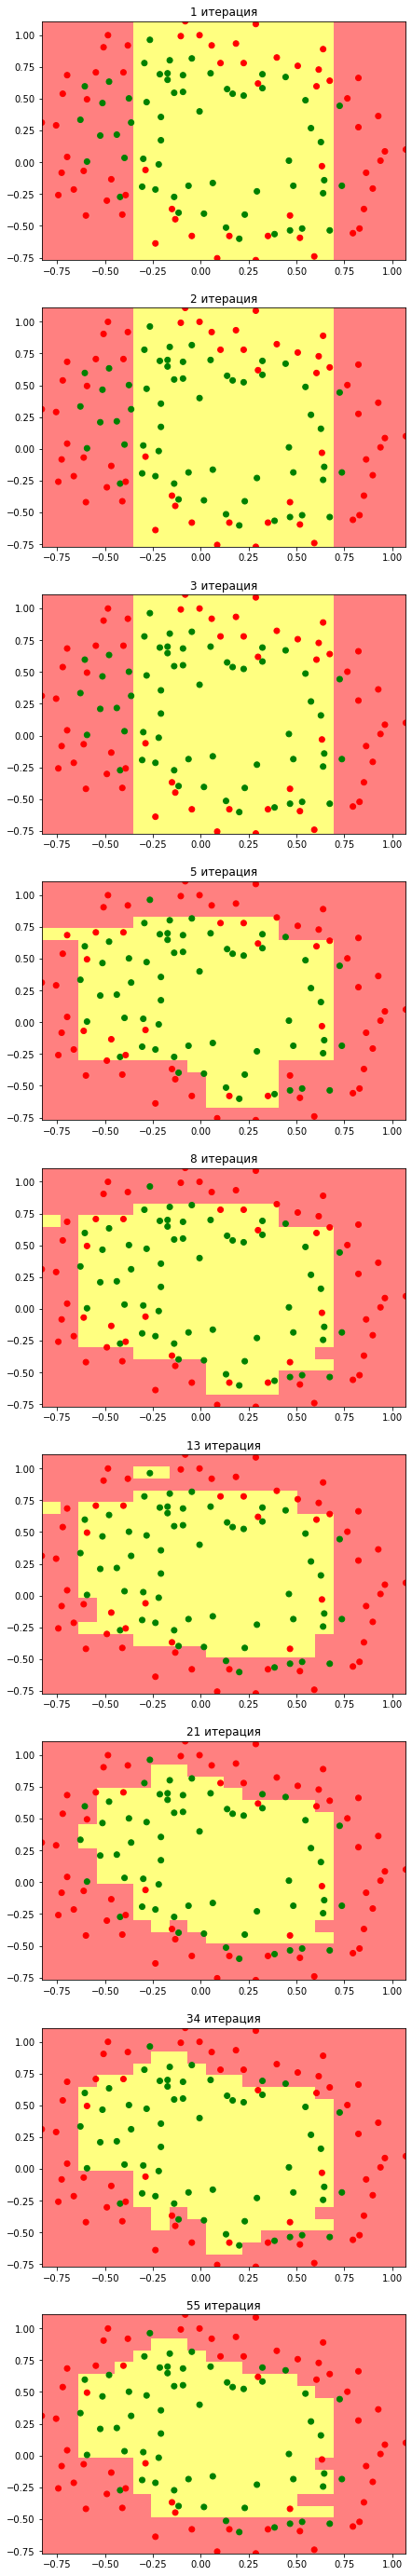

In [9]:
#как алгоритм классифицирует всё пространство после 1, 2, 3, 5, 8, 13, 21, 34 и 55 шага бустинга

iterations = [1, 2, 3, 5, 8, 13, 21, 34, 55]
_, axs = plt.subplots(len(iterations), figsize=(7, 50))

x, y = get_xy(data1)
t = 56
model = AdaBoost(t, max_depth=3, iters_per_node=2)
model.set_data(x, y)
ind = 0
for i, plot_ind in enumerate(iterations):
    while ind < plot_ind:
        model.next_iteration()
        ind += 1

    visualize(axs[i], data1, model)
    axs[i].set_title(f'{plot_ind} итерация')

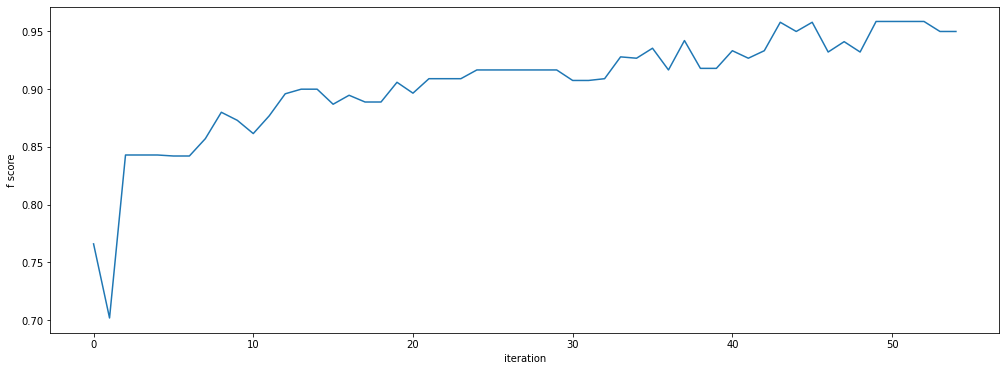

In [10]:
#график зависимости качества Fscore от номера шага
t = 55
model = AdaBoost(t, max_depth=3, iters_per_node=8)
model.set_data(x, y)
iterations = range(t)
f_scores = []
for t in iterations:
    model.next_iteration()
    y_pred = [model.predict(x) for x in x]
    f_scores.append(f1_score(y, y_pred))

_, ax = plt.subplots(1, 1, figsize=(17, 6))
ax.set_xlabel('iteration')
ax.set_ylabel('f score')
ax.plot(iterations, f_scores)